In [1]:

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch
import ssapp.Utils as Utils
torch.manual_seed(42)
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

from ssapp.data.AntennaDatasetLoaders import PatchAntennaDataset
from ssapp.models.NeuralNetworkModels.Autoencoders import PatchAntenna1ConvAutoEncoder, ConvAutoEncoderAndLatentRegressor
from ssapp.models.HelperFunctions import loadModel
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset

fig_save_dir = Path().cwd().parents[1] / 'reports' / 'figures'

BATCH_SIZE = 1
dataset = load_serialized_dataset('PatchAntennaDataset2')
train_data, test_data = Utils.train_test_data_split(dataset, TRAIN_TEST_RATIO = 0.7)


train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)
DEFAULT_CONFIG = {
    "learning_rate": 3e-4,
    "epochs": 10,
    "batch_size": 32,
    "latent_size": 5,
    "random_seed" : 42,
    'coder_channel_1': 16,
    'coder_channel_2': 32,
    'Parameter Number': 3}

model = ConvAutoEncoderAndLatentRegressor(config = DEFAULT_CONFIG)

model = loadModel(model,'rose-forest-25_best_val.pt',subfolder = 'LatentSpaceRegression') # Good 2-dimensional latent space

print(model)


/zhome/5b/b/127277/Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction/models/LatentSpaceRegression/rose-forest-25_best_val.pt
ConvAutoEncoderAndLatentRegressor(
  (batch_norm_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_encoder1): Conv2d(4, 16, kernel_size=(3, 11), stride=(1, 2), padding=(1, 10))
  (conv_encoder2): Conv2d(16, 32, kernel_size=(3, 11), stride=(2, 2))
  (linear_to_latent): Linear(in_features=2816, out_features=5, bias=True)
  (latent_to_linear): Linear(in_features=5, out_features=2816, bias=True)
  (conv_decoder1): ConvTranspose2d(32, 16, kernel_size=(3, 11), stride=(2, 2), output_padding=(0, 1))
  (conv_decoder2): ConvTranspose2d(16, 4, kernel_size=(3, 11), stride=(1, 2), padding=(1, 10))
  (activation): LeakyReLU(n

tensor([[0.2857, 5.2857, 2.9286]])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ValueError: not enough values to unpack (expected 2, got 1)

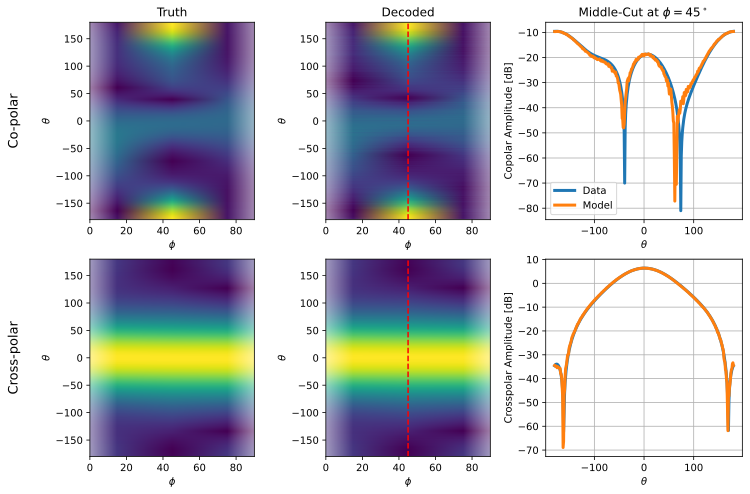

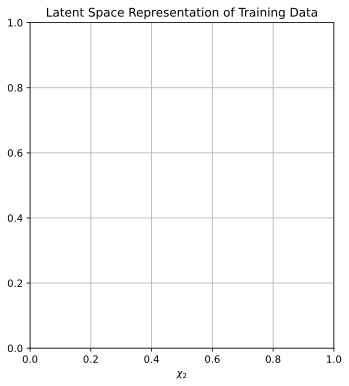

In [2]:
def plotEncodingVerificaiton(model, train_field):
    plt.figure(figsize = (15,10))
    plt.subplot(231)
    plt.imshow(torch.abs(train_field[0,:,:,1:2]),aspect = 1/100)
    plt.subplot(232)
    plt.imshow(torch.abs(model.autoencode_train(train_field.float())[0,:,:,1:2]).detach(),aspect = 1/100) 
    plt.subplot(233)
    plt.plot(10*torch.log10(torch.abs(train_field[0,:,1,1:2])))
    plt.plot(10*torch.log10(torch.abs(model(train_field.float())[0,:,1,1:2])).detach()) 
    plt.subplot(234)
    plt.imshow(torch.abs(train_field[0,:,:,3:4]),aspect = 1/100)
    plt.subplot(235)
    plt.imshow(torch.abs(model.autoencode_train(train_field.float())[0,:,:,3:4]).detach(),aspect = 1/100)
    plt.subplot(236)
    plt.plot(20*torch.log10(torch.abs(train_field[0,:,1,3:4])))
    plt.plot(20*torch.log10(torch.abs(model(train_field.float()))[0,:,1,3:4]).detach()) 
    
def plotEncodingVerificaiton2(model, train_field):

    EXTENT = [0,90,-180,180]
    ASPECT = 0.3
    LINEWIDTH = 3
    X_TEXT_DISPLACEMENT = -45
    thetas = np.linspace(-180,180,361)
    def setImgAxis(ax):
        ax.set_xlabel(r'$ \phi $')
        ax.set_ylabel(r'$ \theta $')
        ax.set_aspect(ASPECT) 

    fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    axs[0,0].imshow(torch.abs(train_field[0,:,:,1:2]),aspect = 1/100, interpolation = 'none',extent=EXTENT)
    axs[0,0].set_title('Truth')
    axs[0,0].text(X_TEXT_DISPLACEMENT,0,'Co-polar',rotation = 'vertical',fontsize = 13, va = 'center')
    setImgAxis(axs[0,0])

    axs[0,1].imshow(torch.abs(model.autoencode_train(train_field.float())[0,:,:,1:2]).detach(), interpolation = 'none',extent=EXTENT)
    axs[0,1].set_title('Decoded')
    axs[0,1].axvline(x = 45, color = 'r', linestyle = '--')
    setImgAxis(axs[0,1])

    axs[0,2].plot(thetas,20*torch.log10(torch.abs(train_field[0,:,1,1:2])),label = 'Data',linewidth = LINEWIDTH)
    axs[0,2].plot(thetas,20*torch.log10(torch.abs(model.autoencode_train(train_field.float())[0,:,1,1:2])).detach(),label = 'Model',linewidth = LINEWIDTH) 
    axs[0,2].grid()
    axs[0,2].set_title('Middle-Cut at $\phi = 45^\circ$')
    axs[0,2].set_xlabel(r'$\theta$')
    axs[0,2].legend()
    axs[0,2].set_ylabel('Copolar Amplitude [dB]')

    axs[1,0].imshow(torch.abs(train_field[0,:,:,3:4]),aspect = 1/100, interpolation = 'none',extent=EXTENT)
    axs[1,0].text(X_TEXT_DISPLACEMENT,0,'Cross-polar',rotation = 'vertical',fontsize = 13, va = 'center')
    setImgAxis(axs[1,0]) 
    

    axs[1,1].imshow(torch.abs(model.autoencode_train(train_field.float())[0,:,:,3:4]).detach(),aspect = 1/100, interpolation = 'none',extent=EXTENT) 
    setImgAxis(axs[1,1])
    axs[1,1].axvline(x = 45, color = 'r', linestyle = '--')

    axs[1,2].plot(thetas,20*torch.log10(torch.abs(train_field[0,:,1,3:4])),linewidth = LINEWIDTH)
    axs[1,2].plot(thetas,20*torch.log10(torch.abs(model.autoencode_train(train_field.float())[0,:,1,3:4])).detach(),linewidth = LINEWIDTH) 
    axs[1,2].set_xlabel(r'$\theta$')
    axs[1,2].grid()
    axs[1,2].set_ylabel('Crosspolar Amplitude [dB]')
    

def plotLatentSpace(model,train_loader,test_loader):
    # Model has to have a 2-dimensional latent space!
    plt.figure(figsize=(12,6))

    plt.subplot(121)
    plt.title('Latent Space Representation of Training Data')
    plt.xlabel("$\chi_1$")
    plt.xlabel("$\chi_2$")
    plt.grid()

    x,y = ([],[])
    plot_params = np.array([])
    for param,fields in train_loader:
        
        x_t,y_t = model.encode(fields.float()).detach().numpy()
        x.append(x_t)
        y.append(y_t)
        plot_params = np.append(plot_params,param.float().detach())

    print('params',plot_params.reshape(-1,3))
    plt.scatter(x,y,c=plot_params.reshape(-1,3)[:,0])



    plt.subplot(122)
    plt.title('Latent Space Representation of Test Data')
    plt.xlabel("$\chi_1$")
    plt.xlabel("$\chi_2$")
    plt.grid()
    for param,fields in test_loader:
        x,y = model.encode(fields.float()).detach().numpy()
        plt.scatter(x,y, c = param[0,1])
    



TRAIN_PARAMS,TRAIN_FIELDS = next(iter(train_loader))
TEST_PARAMS,TEST_FIELDS = next(iter(train_loader))

print(TEST_PARAMS)
plotEncodingVerificaiton2(model,train_field=TEST_FIELDS)
plt.savefig(fig_save_dir / 'Autoencoder_Example.eps', format='eps')
plotLatentSpace(model,train_loader=train_loader,test_loader=test_loader)


/zhome/5b/b/127277/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/zhome/5b/b/127277/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[6.62377525e-01 2.99145390e-01 2.27238945e-02 1.54881270e-02
 2.52483970e-04 7.09478614e-06 3.20468971e-06 1.21585498e-06
 8.02040153e-07 1.24381244e-07]
0.9999998619773235
torch.Size([240, 4332])
torch.Size([240, 3])


/tmp/ipykernel_2398/1031789366.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])
/tmp/ipykernel_2398/1031789366.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])


ValueError: not enough values to unpack (expected 2, got 1)

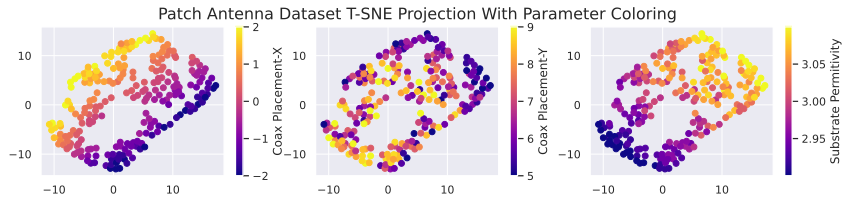

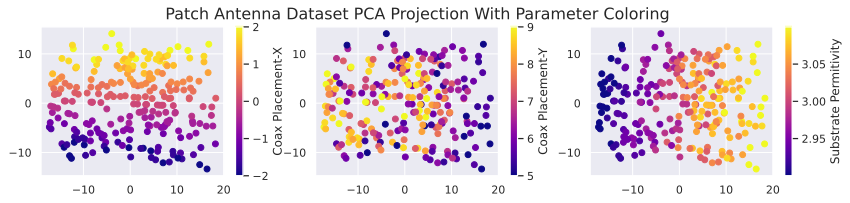

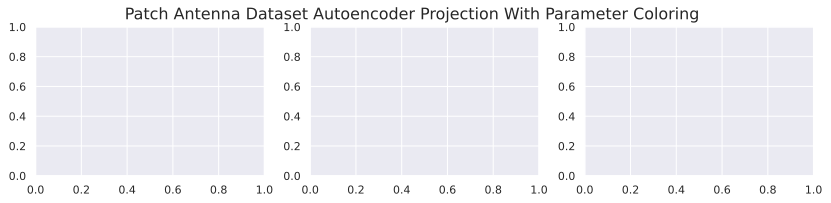

In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
sns.set_theme()
bs = 240

train_loader_plt = DataLoader(train_data,batch_size=bs,shuffle=True)
test_loader_plt = DataLoader(test_data,batch_size=bs,shuffle=True)
TRAIN_PARAMS,TRAIN_FIELDS = next(iter(train_loader_plt))
TEST_PARAMS,TEST_FIELDS = next(iter(train_loader_plt))


tsne = TSNE(n_components=2, perplexity=30, n_iter=5000,init='pca')
pca = PCA(n_components=10)


tsne_results = tsne.fit_transform(TEST_FIELDS.reshape((bs,-1)))
pca_results = pca.fit_transform(TEST_FIELDS.reshape((bs,-1)))
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

print(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)).shape)
print(TEST_PARAMS.reshape((len(TEST_FIELDS),-1)).shape)

param_names = ['Coax Placement-X','Coax Placement-Y','Substrate Permitivity']

fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (14,2.75))
fig.suptitle('Patch Antenna Dataset T-SNE Projection With Parameter Coloring', fontsize = 16)
for i in range(0,3):
    im = axs[i].scatter(tsne_results[:,0],tsne_results[:,1],c = TEST_PARAMS[:,i],cmap = 'plasma')
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])

plt.savefig(fig_save_dir / 'T_Sne.eps', format='eps')

fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (14,2.75))
fig.suptitle('Patch Antenna Dataset PCA Projection With Parameter Coloring', fontsize = 16)
for i in range(0,3):
    im = axs[i].scatter(pca_results[:,0],pca_results[:,1],c = TEST_PARAMS[:,i],cmap = 'plasma')
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])


plt.savefig(fig_save_dir / 'PCA.eps', format='eps')
fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (14,2.75))
fig.suptitle('Patch Antenna Dataset Autoencoder Projection With Parameter Coloring', fontsize = 16)
for i in range(0,3):
    x,y = ([],[])
    plot_params = np.array([])
    for param,fields in train_loader:
        
        x_t,y_t = model.encode(fields.float()).detach().numpy()
        x.append(x_t)
        y.append(y_t)
        plot_params = np.append(plot_params,param.float().detach())

    im = axs[i].scatter(x,y,c=plot_params.reshape(-1,3)[:,i],cmap = 'plasma')
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])

plt.savefig(fig_save_dir / 'Autoencoder_Latent_Space_Parameter_plots.eps', format='eps')

Text(0.5, 1.0, 'Patch Antenna Variance Explained by Prinicipal Components')

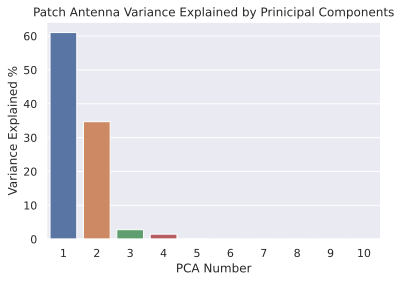

In [5]:

plt.figure()
sns.barplot(x = list(range(1,1+len(pca.explained_variance_ratio_))),y = pca.explained_variance_ratio_*100)
plt.xlabel('PCA Number')
plt.ylabel('Variance Explained %')
plt.title('Patch Antenna Variance Explained by Prinicipal Components')


array([[[-5.04187500e-02, -5.04149948e-02, -5.04052004e-02, ...,
          2.67365293e-02,  2.67433907e-02,  2.67437630e-02],
        [ 4.68297440e-03,  4.68297440e-03,  4.68297440e-03, ...,
         -9.67194919e-04, -9.67194919e-04, -9.23118724e-04],
        [ 3.30902893e-03,  3.30946851e-03,  3.30946851e-03, ...,
          4.65238994e-03,  4.67340157e-03,  4.61730337e-03],
        ...,
        [ 3.76506709e-03,  3.64667955e-03,  3.88670706e-03, ...,
          7.92384327e-03,  7.63950400e-03,  7.78056890e-03],
        [ 1.71868278e-02,  1.73925201e-02,  1.69805598e-02, ...,
          2.11120052e-02,  2.07393924e-02,  2.09264684e-02],
        [-5.09968053e-04, -5.08077962e-04, -5.10587015e-04, ...,
          3.10084415e-04,  2.92746993e-04,  2.75739136e-04]],

       [[-5.14533622e-03, -5.14506897e-03, -5.13212016e-03, ...,
          2.43412696e-03,  2.43447713e-03,  2.43463642e-03],
        [-5.07683836e-02, -5.07683836e-02, -5.07683836e-02, ...,
          9.28511123e-03,  9.28511123e

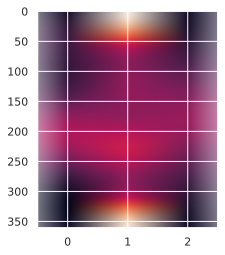

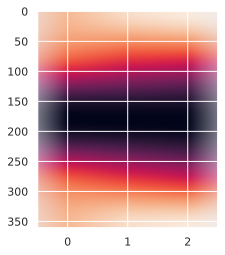

In [6]:
pca = PCA(n_components=10)



pca_results = pca.fit_transform(TEST_FIELDS.reshape((bs,-1)))




for i in range(0,2):
    plt.figure()
    plt.imshow(pca.components_.reshape(10,361,3,4)[i,:,:,0],aspect = 1/100,interpolation='none')




components_indicies = np.argsort(pca.components_)
pca.components_[:,components_indicies]

/tmp/ipykernel_7782/1870799787.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surf, shrink=0.5, aspect=5)


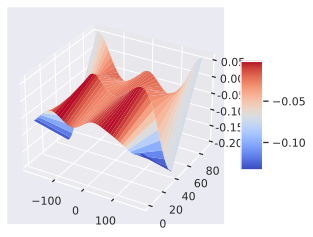

In [7]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
theta = np.linspace(-180, 180, 361)
phi = np.linspace(0, 90, 3)
theta, phi = np.meshgrid(theta, phi)

from matplotlib import cm
from matplotlib.ticker import LinearLocator
# Plot the surface.
surf = ax.plot_surface(theta, phi, TEST_FIELDS[0,:,:,0].T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from ssapp.data.AntennaDatasetLoaders import ReflectorCutDataset

data = ReflectorCutDataset()

bs = len(data)

train_loader = DataLoader(data,batch_size=bs,shuffle=True)

TEST_PARAMS,TEST_FIELDS = next(iter(train_loader))

tsne = TSNE(n_components=2, perplexity=50, n_iter=300,init='pca')
pca = PCA(n_components=10)

tsne_results = tsne.fit_transform(TEST_FIELDS.reshape((bs,-1)))
pca_results = pca.fit_transform(TEST_FIELDS.reshape((bs,-1)))
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

print(TEST_PARAMS.reshape((len(TEST_FIELDS),-1)).shape)

param_names = ['Reflector Diameter','Focal Length','Offset']

/zhome/5b/b/127277/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/zhome/5b/b/127277/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[0.45890987 0.44814514 0.03505349 0.03329597 0.00750699 0.00725501
 0.00240142 0.00231143 0.0009619  0.0009472 ]
0.9967884124878168
torch.Size([2499, 3])


/tmp/ipykernel_7782/3582101982.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])
/tmp/ipykernel_7782/3582101982.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])
/tmp/ipykernel_7782/3582101982.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])


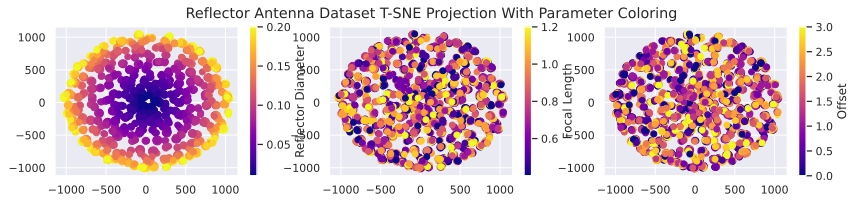

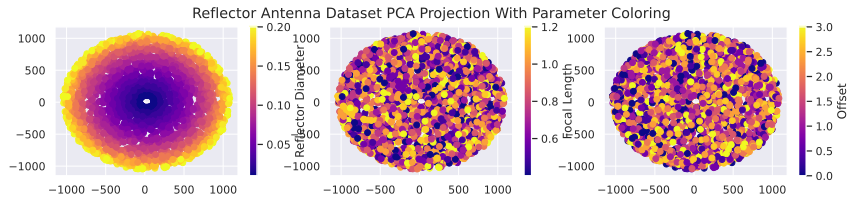

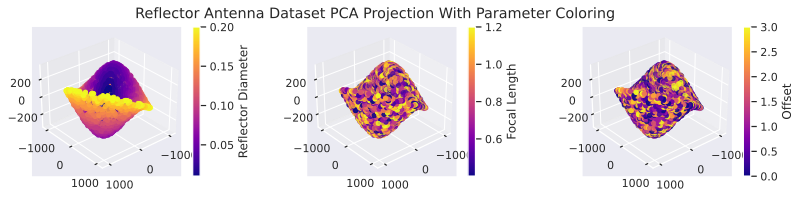

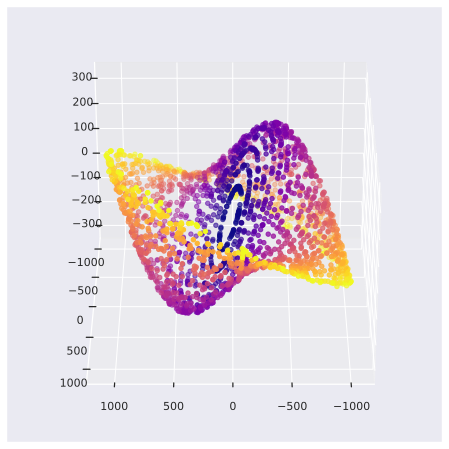

In [12]:





fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (14,2.75))
fig.suptitle('Reflector Antenna Dataset T-SNE Projection With Parameter Coloring')
for i in range(0,3):
    im = axs[i].scatter(tsne_results[:,0],tsne_results[:,1],c = TEST_PARAMS[:,i],cmap = 'plasma')
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])


fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (14,2.75))
fig.suptitle('Reflector Antenna Dataset PCA Projection With Parameter Coloring')
for i in range(0,3):
    im = axs[i].scatter(pca_results[:,0],pca_results[:,1],c = TEST_PARAMS[:,i],cmap = 'plasma')
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])


fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (14,2.75),subplot_kw=dict(projection='3d'))
fig.suptitle('Reflector Antenna Dataset PCA Projection With Parameter Coloring')
for i in range(0,3):
    axs[i].view_init(30, 50)
    im = axs[i].scatter(pca_results[:,0],pca_results[:,1],pca_results[:,2],c = TEST_PARAMS[:,i],cmap = 'plasma')
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 90)
ax.scatter(pca_results[:,0],pca_results[:,1],pca_results[:,2],c = TEST_PARAMS[:,0],cmap = 'plasma',)







/tmp/ipykernel_7782/2850049593.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs)


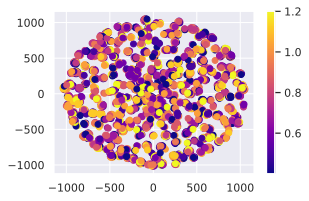

In [22]:
fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (4.5,3))
im = axs.scatter(tsne_results[:,0],tsne_results[:,1],c = TEST_PARAMS[:,1],cmap = 'plasma')
cbar = plt.colorbar(im,ax=axs)

plt.savefig('Cirkel Plot Til Oscar.png', format='png',dpi = 400)


Text(0.5, 1.0, 'Simple Reflector Variance Explained by Prinicipal Components')

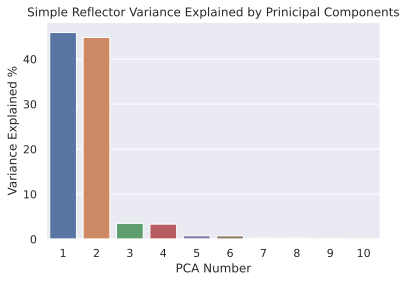

In [ ]:
plt.figure()
sns.barplot(x = list(range(1,1+len(pca.explained_variance_ratio_))),y = pca.explained_variance_ratio_*100)
plt.xlabel('PCA Number')
plt.ylabel('Variance Explained %')
plt.title('Simple Reflector Variance Explained by Prinicipal Components')

[5.75211114e-01 4.21824710e-01 1.50156511e-03 1.02240212e-03
 1.81585463e-04 1.16192333e-04 1.77206918e-05 1.07597155e-05
 7.70110294e-06 5.74049419e-06]
0.9998994912767614
torch.Size([360, 3])


/tmp/ipykernel_191213/2768899169.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])


Text(0.5, 1.0, 'Simple Reflector Variance Explained by Prinicipal Components')

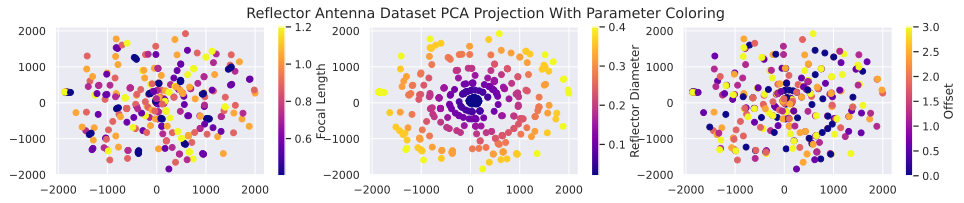

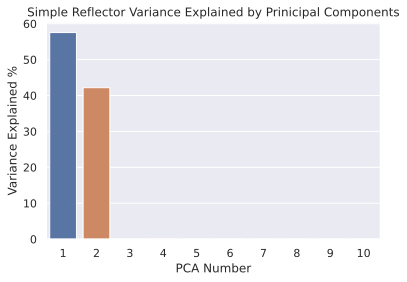

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from ssapp.data.AntennaDatasetLoaders import ReflectorCutDataset2

data = ReflectorCutDataset2()

train_loader = DataLoader(data,batch_size=len(data),shuffle=True)

TEST_PARAMS,TEST_FIELDS = next(iter(train_loader))

#tsne = TSNE(n_components=2, perplexity=50, n_iter=300,init='pca')
pca = PCA(n_components=10)


pca_results = pca.fit_transform(TEST_FIELDS.reshape((len(data),-1)))
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

print(TEST_PARAMS.reshape((len(TEST_FIELDS),-1)).shape)

param_names = ['Focal Length','Reflector Diameter','Offset']


fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (16,2.75))
fig.suptitle('Reflector Antenna Dataset PCA Projection With Parameter Coloring')
for i in range(0,3):
    im = axs[i].scatter(pca_results[:,0],pca_results[:,1],c = TEST_PARAMS[:,i],cmap = 'plasma')
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])


plt.figure()
sns.barplot(x = list(range(1,1+len(pca.explained_variance_ratio_))),y = pca.explained_variance_ratio_*100)
plt.xlabel('PCA Number')
plt.ylabel('Variance Explained %')
plt.title('Simple Reflector Variance Explained by Prinicipal Components')

In [ ]:

data_reflector = ReflectorCutDataset2()
data_patch = PatchAntennaDataset()

REFLECTOR_FIELDS torch.Size([360, 361, 3, 4])
PATCH_FIELDS torch.Size([343, 361, 3, 4])
REFLECTOR_FIELDS torch.Size([360, 4332])
PATCH_FIELDS torch.Size([343, 4332])
(703, 4332)


/zhome/5b/b/127277/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/zhome/5b/b/127277/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[5.75134421e-01 4.21342268e-01 1.50463851e-03 1.02543296e-03
 4.50585473e-04 1.80297908e-04 1.16007610e-04 6.75509380e-05
 3.40854314e-05 1.76644357e-05]
0.9998729516287729


/tmp/ipykernel_191213/2786008568.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])
/tmp/ipykernel_191213/2786008568.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im,ax=axs[i])


Text(0.5, 1.0, 'Simple Reflector Variance Explained by Prinicipal Components')

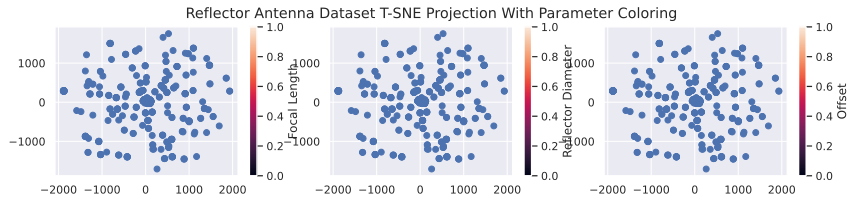

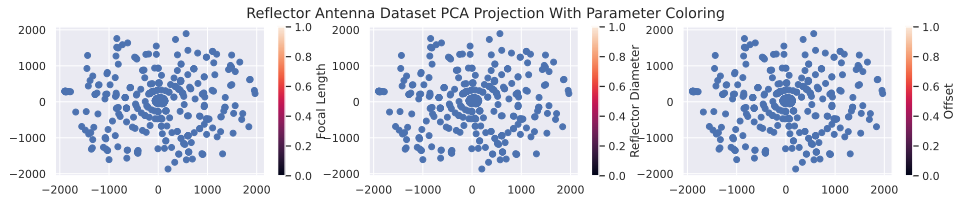

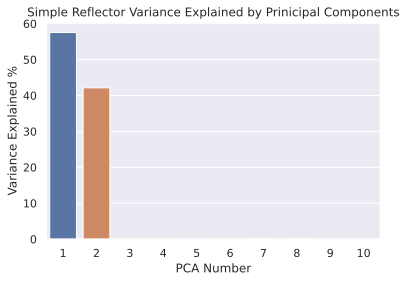

In [ ]:



dataloader_reflector = DataLoader(data_reflector,batch_size=len(data_reflector),shuffle=True)


dataloader_patch = DataLoader(data_patch,batch_size=len(data_patch),shuffle=True)
TEST_PARAMS,REFLECTOR_FIELDS = next(iter(dataloader_reflector))
TEST_PARAMS,PATCH_FIELDS = next(iter(dataloader_patch))
print('REFLECTOR_FIELDS',REFLECTOR_FIELDS.shape)
print('PATCH_FIELDS',PATCH_FIELDS.shape)

#tsne = TSNE(n_components=2, perplexity=50, n_iter=300,init='pca')

REFLECTOR_FIELDS = REFLECTOR_FIELDS.reshape(len(data_reflector),-1)
PATCH_FIELDS = PATCH_FIELDS.reshape(len(data_patch),-1)
print('REFLECTOR_FIELDS',REFLECTOR_FIELDS.shape)
print('PATCH_FIELDS',PATCH_FIELDS.shape)
ALL_DATA = np.append(REFLECTOR_FIELDS,PATCH_FIELDS,axis=0)
print(ALL_DATA.shape)

tsne = TSNE(n_components=2, perplexity=50, n_iter=300,init='pca')
pca = PCA(n_components=10)

pca_results = pca.fit_transform(ALL_DATA)
tsne_results = tsne.fit_transform(ALL_DATA)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))


param_names = ['Focal Length','Reflector Diameter','Offset']


fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (14,2.75))
fig.suptitle('Reflector Antenna Dataset T-SNE Projection With Parameter Coloring')
for i in range(0,3):
    im = axs[i].scatter(tsne_results[:,0],tsne_results[:,1])
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])


fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize = (16,2.75))
fig.suptitle('Reflector Antenna Dataset PCA Projection With Parameter Coloring')
for i in range(0,3):
    im = axs[i].scatter(pca_results[:,0],pca_results[:,1])
    cbar = plt.colorbar(im,ax=axs[i])
    cbar.set_label(param_names[i])


plt.figure()
sns.barplot(x = list(range(1,1+len(pca.explained_variance_ratio_))),y = pca.explained_variance_ratio_*100)
plt.xlabel('PCA Number')
plt.ylabel('Variance Explained %')
plt.title('Simple Reflector Variance Explained by Prinicipal Components')

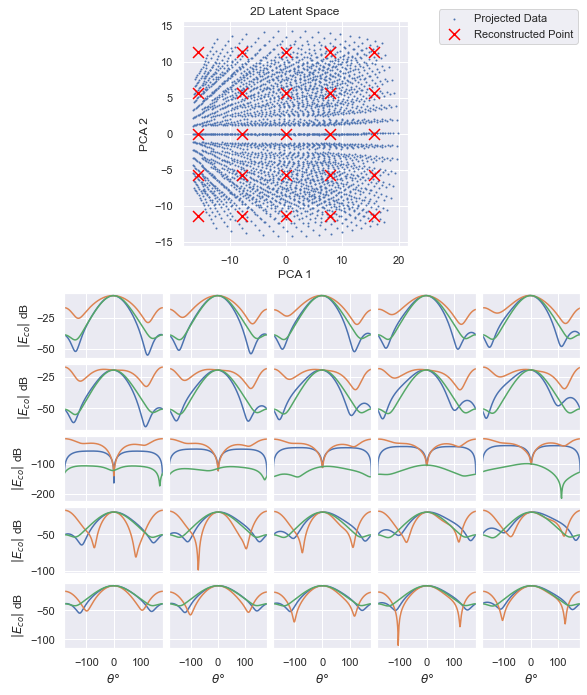

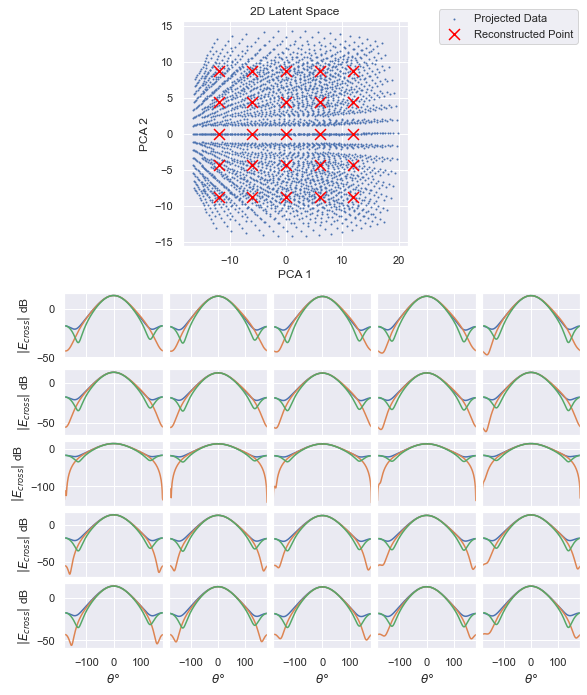

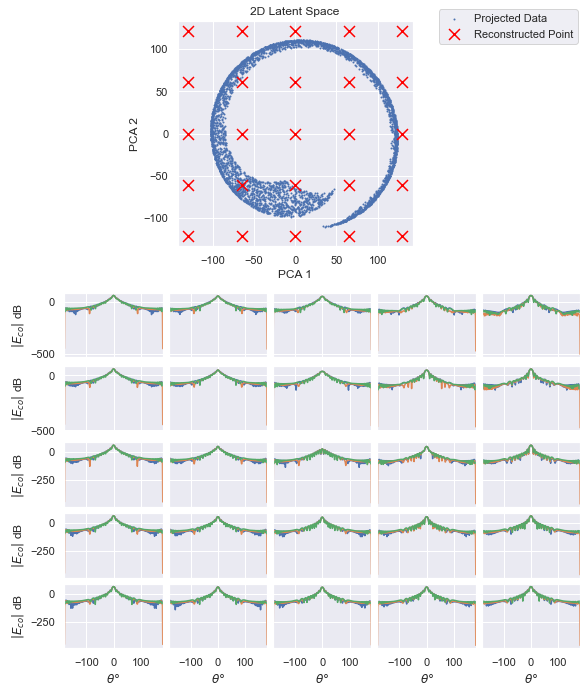

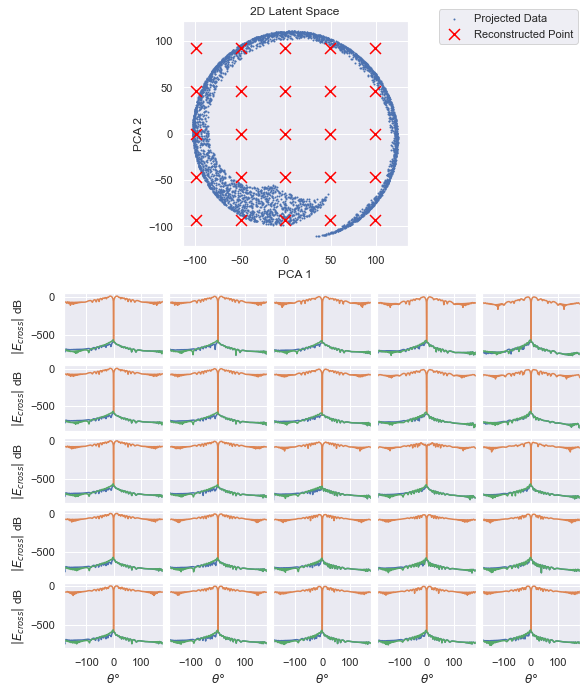

In [2]:
from ssapp.visualization.PCA_Visualisation import plotInverseTransformStandardPCA
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset

datasets = [load_serialized_dataset('PatchAntennaDataset2'),
            load_serialized_dataset('CircularHornDataset1')]

for dataset in datasets:
    plotInverseTransformStandardPCA(dataset,num_std_dev=1.7,
                                num_rows =5,
                                phi_cut =[0,1,2],
                                phi_labels = ['$\phi = 0$','$\phi = 45$','$\phi = 90$'],
                                component = 'co', 
                                num_cols = 5)

    plotInverseTransformStandardPCA(dataset,num_std_dev=1.3,
                                    num_rows =5,
                                    phi_cut =[0,1,2],
                                    phi_labels = ['$\phi = 0$','$\phi = 45$','$\phi = 90$'],
                                    component = 'cross', 
                                    num_cols = 5)

In [ ]:
params = [1,2,3]


